<a href="https://colab.research.google.com/github/aim56009/bias_gan_t_p/blob/main/code/tas_prec_gan.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports 

In [1]:
is_colab = True

if is_colab==False:
    colab_path = "bias_gan_t_p/"
else:
    colab_path = "/content/gdrive/MyDrive/bias_gan_t_p"

In [ ]:
"""
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)
"""

"\ngpu_info = !nvidia-smi\ngpu_info = '\n'.join(gpu_info)\nif gpu_info.find('failed') >= 0:\n  print('Not connected to a GPU')\nelse:\n  print(gpu_info)\n"

In [ ]:
if is_colab == True:
    from google.colab import drive
    drive.mount("/content/gdrive")

In [ ]:
if is_colab == True:
    !git clone https://github.com/aim56009/bias_gan_t_p.git
    !pip install cftime

In [ ]:
%%capture
!pip install pytorch_lightning
from pytorch_lightning.loggers import TensorBoardLogger
!pip install basemap
!pip install importlib-metadata==4.0.1
!pip install xarray==0.18.1
!pip install torchvision

In [ ]:
if is_colab == False:
    import os
    os.chdir('/dss/dsshome1/0D/ge74xuf2/')

In [ ]:
import os
import xarray as xr
import torch
import json
import glob
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pytorch_lightning as pl
import argparse
import pathlib
import cv2
import matplotlib


from tensorboard.backend.event_processing import event_accumulator
from pytorch_lightning.callbacks import Callback
from datetime import datetime
from io import BytesIO
from PIL import Image
from dataclasses import dataclass, field
from typing import List


#from Bias_GAN.code.src.model import CycleGAN, Generator, DataModule                     
from bias_gan_t_p.code.src.model import CycleGAN, Generator#, DataModule                     

#from Bias_GAN.code.src.data import TestData, CycleDataset
from bias_gan_t_p.code.src.utils import get_version, set_environment, get_checkpoint_path, save_config, log_transform, inv_norm_transform, inv_log_transform, inv_norm_minus1_to_plus1_transform, norm_minus1_to_plus1_transform 
from bias_gan_t_p.code.src.plots import PlotAnalysis, plot_basemap
from bias_gan_t_p.code.src.callbacks import get_cycle_gan_callbacks, MAE_Callback
from bias_gan_t_p.code.src.inference import Inference, EvaluateCheckpoints, create_folder

/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


# Data.py

In [ ]:
class DataModule(pl.LightningDataModule):

    def __init__(self,
                 config,
                 training_batch_size: int = 4,
                 test_batch_size: int = 64):


        super().__init__()

        self.config = config
        self.training_batch_size = training_batch_size
        self.test_batch_size = test_batch_size

    def setup(self, stage: str = None):

        if stage == 'fit' or stage is None:
            self.train = CycleDataset('train', self.config)
            self.valid = CycleDataset('valid', self.config)

        if stage == 'test':
            self.test = CycleDataset('test', self.config)
            self.valid = CycleDataset('valid', self.config)

 

    def train_dataloader(self):
        return DataLoader(self.train,
                         batch_size=self.training_batch_size,
                         shuffle=True,
                         num_workers=80,
                         pin_memory=True)


    def val_dataloader  (self):
        return DataLoader(self.valid,
                          batch_size=self.test_batch_size,
                          shuffle=False,
                          num_workers=10,
                          pin_memory=True)


    def test_dataloader (self):
        return DataLoader(self.test,
                          batch_size=self.test_batch_size,
                          shuffle=False,
                          num_workers=10,
                          pin_memory=True)


def show_image(image):
    plt.imshow((image.squeeze()))


def get_random_sample(dataset):
    return dataset[np.random.randint(0, len(dataset))]


In [ ]:
from dataclasses import dataclass
import cftime
from torch.utils.data import DataLoader


@dataclass
class TestData():
    
    era5: xr.DataArray
    gan: xr.DataArray
    climate_model: xr.DataArray = None
    uuid: str = None
    model = None
    

    def model_name_definition(self, key):
        dict = {
            'era5': 'ERA5',
            'gan': 'GAN (unconstrained)',
            'climate_model': 'Climate model',
        }
        return dict[key]


    def colors(self, key):
        dict = {
            'era5': 'k',
            'gan': 'brown',
            'climate_model': 'r',
        }
        return dict[key]

        
    def convert_units(self):
        """ from mm/s to mm/d"""
        climate_model_pr = self.climate_model.precipitation*3600*24
        era5_pr = self.era5.precipitation*3600*24
        gan_pr = self.gan.precipitation*3600*24
        
        
        self.era5['precipitation'] = era5_pr
        self.climate_model['precipitation'] = climate_model_pr
        self.gan['precipitation'] = gan_pr
    
    def crop_test_period(self):
        print('')
        print(f'Test set period: {self.gan.tas.time[0].values} - {self.gan.tas.time[-1].values}')
        
        climate_model_pr = self.climate_model.precipitation.sel(time=slice(self.gan.tas.time[0], self.gan.tas.time[-1]))
        climate_model_t = self.climate_model.tas.sel(time=slice(self.gan.tas.time[0], self.gan.tas.time[-1]))
        era5_pr = self.era5.precipitation.sel(time=slice(self.gan.tas.time[0], self.gan.tas.time[-1]))
        era5_t = self.era5.tas.sel(time=slice(self.gan.tas.time[0], self.gan.tas.time[-1]))
        
        self.era5['precipitation'] = era5_pr
        self.climate_model['precipitation'] = climate_model_pr
        
        self.era5['tas'] = era5_t
        self.climate_model['tas'] = climate_model_t
        
    def show_mean(self):
        print('')
        print(f'Mean precipitation [mm/d]:')
        print(f'ERA5: {self.era5_pr.mean().values:2.3f}')
        print(f'Climate Model: {self.climate_model_pr.mean().values:2.3f}')
        print(f'GAN:  {self.gan.precipitation.mean().values:2.3f}')
        
        print('')
        print(f'Mean temperature [K]:')
        print(f'ERA5: {self.era5_t.mean().values:2.3f}')
        print(f'Climate Model: {self.climate_model_t.mean().values:2.3f}')
        print(f'GAN:  {self.gan.tas.mean().values:2.3f}')



class CycleDataset(torch.utils.data.Dataset):
    
    def __init__(self, stage, config, epsilon=0.001): #=0.0001):
        """ 
            stage: train, valid, test
        """
        self.transforms = config.transforms
        self.epsilon = epsilon
        self.config = config

        if config.lazy:
            self.cache = False
            self.chunks = {'time': 1}
        else:#this
            self.cache = True
            self.chunks = None
        
        self.splits = {
                "train": [str(config.train_start), str(config.train_end)],
                "valid": [str(config.valid_start), str(config.valid_end)],
                "test":  [str(config.test_start), str(config.test_end)],
        }

        self.stage = stage
        
        self.climate_model = self.load_climate_model_data()
        climate_model_reference = self.load_climate_model_data(is_reference=True)
        
        self.era5 = self.load_era5_data()
        era5_reference = self.load_era5_data(is_reference=True)

        self.num_samples = len(self.era5.tas.time.values)
        
        self.era5 = self.apply_transforms(self.era5, era5_reference)
        self.climate_model = self.apply_transforms(self.climate_model, climate_model_reference)



    def load_climate_model_data(self, is_reference=False):
        """ Y-domain samples """

        climate_model_pr = xr.open_dataset(self.config.model_pr_path, cache=self.cache, chunks=self.chunks)
        climate_model_pr =  climate_model_pr.precipitation
                
        climate_model_t = xr.open_dataset(self.config.model_t_path, cache=self.cache, chunks=self.chunks)
        climate_model_t =  climate_model_t.tas
                

        if not self.config.lazy:
            climate_model_pr = climate_model_pr.load()
            climate_model_t = climate_model_t.load()

        if is_reference:
            climate_model_pr = climate_model_pr.sel(time=slice(self.splits['train'][0], self.splits['train'][1]))
            climate_model_t = climate_model_t.sel(time=slice(self.splits['train'][0], self.splits['train'][1]))
        else:
            climate_model_pr = climate_model_pr.sel(time=slice(self.splits[self.stage][0],self.splits[self.stage][1]))
            climate_model_t = climate_model_t.sel(time=slice(self.splits[self.stage][0],self.splits[self.stage][1]))
        
        
        climate_model = xr.Dataset({'precipitation': climate_model_pr, 'tas': climate_model_t})

        return climate_model


    def load_era5_data(self, is_reference=False):
        """ X-domain samples """

        era5_pr = xr.open_dataset(self.config.era5_pr_path,cache=self.cache, chunks=self.chunks).era5_precipitation
        era5_t = xr.open_dataset(self.config.era5_t_path,cache=self.cache, chunks=self.chunks).tas

        if not self.config.lazy:
            era5_pr = era5_pr.load()
            era5_t = era5_t.load()

        if is_reference:
            era5_pr = era5_pr.sel(time=slice(self.splits['train'][0],self.splits['train'][1]))
            era5_t = era5_t.sel(time=slice(self.splits['train'][0],self.splits['train'][1]))

        else:
            era5_pr = era5_pr.sel(time=slice(self.splits[self.stage][0], self.splits[self.stage][1]))
            era5_t = era5_t.sel(time=slice(self.splits[self.stage][0], self.splits[self.stage][1]))    
        
        era5 = xr.Dataset({'precipitation': era5_pr, 'tas': era5_t})

        return era5
        

    def apply_transforms(self, data, data_ref):
        
        data_prec = data.precipitation
        data_tas = data.tas
                
        data_prec_ref = data_ref.precipitation
        data_tas_ref = data_ref.tas
        
                
        if 'log' in self.transforms:
            data_prec = log_transform(data_prec, self.epsilon)
            data_prec_ref = log_transform(data_prec_ref, self.epsilon)

        if 'normalize' in self.transforms:
            data = norm_transform(data, data_ref)

        if 'normalize_minus1_to_plus1' in self.transforms:
            data_prec = norm_minus1_to_plus1_transform(data_prec, data_prec_ref)
            data_tas = norm_minus1_to_plus1_transform(data_tas, data_tas_ref)
        
        data_ref['precipitation'] = data_prec_ref
        
        data['precipitation'] = data_prec
        data['tas'] = data_tas
        
                
        return data


    def __getitem__(self, index):
        
        x_p = torch.from_numpy(self.era5.precipitation.isel(time=index).values).float().unsqueeze(0)
        x_t = torch.from_numpy(self.era5.tas.isel(time=index).values).float().unsqueeze(0)
        x = torch.cat((x_p, x_t), dim=0)
        
        y_p = torch.from_numpy(self.climate_model.precipitation.isel(time=index).values).float().unsqueeze(0)
        y_t = torch.from_numpy(self.climate_model.tas.isel(time=index).values).float().unsqueeze(0)
        y = torch.cat((y_p, y_t), dim=0)
        
        #print("check for nan:",torch.sum(x),torch.sum(y))
        
        sample = {'A': x, 'B': y}
        
        return sample

    def __len__(self):
        return self.num_samples

In [ ]:
#Config_adjusted_trafo = Config
#nbr_reconstruction_examples = 1
#Config_adjusted_trafo.transforms = Config_adjusted_trafo.transformations
#dataset = CycleDataset('train', Config_adjusted_trafo)

In [ ]:
#datamodule = DataModule(Config, training_batch_size = Config.train_batch_size, test_batch_size = Config.test_batch_size)
#datamodule.setup("fit")
#train_loader = datamodule.train_dataloader()

#for batch_idx, data in enumerate(train_loader):
#    data["A"]
#    data["B"]

In [ ]:
track_lat_mean = True
plt_hist=True
accelerator= "gpu"

#train_cycle_gan(Config(),validation=False,track_lat_mean=track_lat_mean,plt_hist=plt_hist)

# Main training loop

## define MAE callback

In [ ]:
class MAE_Callback(Callback):
    def __init__(self,logger,checkpoint_path,config, validation=True, lat_mean=False, plt_hist=False):
        self.MAE_list_pr = []
        self.MAE_list_t = []
        self.logger = logger
        self.checkpoint_path = checkpoint_path
        self.config = config
        self.version = get_version(config.date,config.time)
        self.validation = validation
        self.lat_mean = lat_mean
        self.plt_hist = plt_hist
        

    def on_train_epoch_end(self, trainer, pl_module):
        checkpoint_files = glob.glob(str(self.checkpoint_path) + '/*.ckpt')
        if not checkpoint_files:
            test_data_ = None
        else:
            last_checkpoint = max(checkpoint_files, key=os.path.getctime)
            data = EvaluateCheckpoints(checkpoint_path=last_checkpoint, config_path=self.config.config_path + self.version + "/config_model.json", save_model=True,validation=self.validation, version=self.version)
            _, reconstruction_data = data.run()
            test_data_ = data.get_test_data()


        if test_data_ is None or not test_data_:
            print("No test data available.")
            return

        gan_data = getattr(test_data_, 'gan')
        era5_data = getattr(test_data_, "era5")
        
        bias_pr = gan_data.precipitation.mean('time') - era5_data.precipitation.mean('time') 
        print("GAN-OBS precipitation",f" \t \t MAE: {abs(bias_pr).values.mean():2.3f} [mm/d]")
        self.MAE_list_pr.append(abs(bias_pr).values.mean())
        print("MAE_list precipitation:",self.MAE_list_pr)
        self.log('MAE p', abs(bias_pr).values.mean())
        print("")
        bias_t = gan_data.tas.mean('time') - era5_data.tas.mean('time') 
        print("GAN-OBS tas",f" \t \t MAE: {abs(bias_t).values.mean():2.3f} [K]")
        self.MAE_list_t.append(abs(bias_t).values.mean())
        print("MAE_list tas:",self.MAE_list_t)
        self.log('MAE t', abs(bias_t).values.mean())
        print("")

        if test_data_ is not None and self.lat_mean==True:
            data_era5_pr = era5_data.precipitation.mean(dim=("longitude", "time"))
            data_era5_t = era5_data.tas.mean(dim=("lon", "time"))
            
            data_gan_pr= gan_data.precipitation.mean(dim=("longitude", "time"))
            data_gan_t= gan_data.tas.mean(dim=("longitude", "time"))
            
            plt.figure()
            
            plt.plot(data_gan_pr.latitude, data_gan_pr.data,
                      label="gan precipitation",
                      alpha=0.9,
                      linestyle='-',
                      linewidth=2,
                      color="red")
            
            plt.plot(data_era5_pr.latitude, data_era5_pr.data,
                      label="era5 precipitation",
                      alpha=1,
                      linestyle='--',
                      linewidth=2,
                      color="black")
            
            #plt.ylim(0,3)
            plt.xlim(25,58)
            plt.xlabel('Latitude')
            plt.ylabel('Mean precipitation [mm/d]')
            plt.grid()
            plt.legend(loc='upper right')  
            
            buf = BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            im = Image.open(buf)
            img = torchvision.transforms.ToTensor()(im)
            
            self.logger.experiment.add_image(f"latitudinal_mean precipitation", img, trainer.current_epoch)
            
            
            ###
            plt.figure()
            
            plt.plot(data_gan_t.latitude, data_gan_t.data,
                      label="gan temperature",
                      alpha=0.9,
                      linestyle='-',
                      linewidth=2,
                      color="red")
            
            plt.plot(data_era5_t.lat, data_era5_t.data,
                      label="era5 temperature",
                      alpha=1,
                      linestyle='--',
                      linewidth=2,
                      color="black")
            
            #plt.ylim(0,3)
            plt.xlim(25,58)
            plt.xlabel('Latitude')
            plt.ylabel('Mean temperature [K]')
            plt.grid()
            plt.legend(loc='upper right')
            #plt.show()
            ###
            
            buf = BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            im = Image.open(buf)
            img = torchvision.transforms.ToTensor()(im)
            
            self.logger.experiment.add_image(f"latitudinal_mean temperature", img, trainer.current_epoch)

        if test_data_ is not None and self.plt_hist==True:
            data_gan_pr = getattr(test_data_, "gan").precipitation.values.flatten()
            data_era5_pr = getattr(test_data_, "era5").precipitation.values.flatten()
            plt.figure()
            _ = plt.hist(data_gan_pr,
                        bins=100,
                        histtype='step',
                        log=True,
                        label="gan",
                        alpha=0.9,
                        density=True,
                        linewidth=2,
                        color="red")
            
            _ = plt.hist(data_era5_pr,
                        bins=100,
                        histtype='step',
                        log=True,
                        label="era5",
                        alpha=1,
                        density=True,
                        linewidth=2,
                        color="black")

            plt.xlabel('Precipitation [mm/d]')
            plt.ylabel('Histogram')
            #plt.xlim(0,400)
            plt.grid()
            plt.legend(loc='upper right')

            #plt.show()
            buf = BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            im_ = Image.open(buf)
            img_ = torchvision.transforms.ToTensor()(im_)
            
            self.logger.experiment.add_image(f"histogram precipitation", img_, trainer.current_epoch)
            
            
            data_gan_t = getattr(test_data_, "gan").tas.values.flatten()
            data_era5_t = getattr(test_data_, "era5").tas.values.flatten()
            plt.figure()
            _ = plt.hist(data_gan_t,
                        bins=100,
                        histtype='step',
                        log=True,
                        label="gan",
                        alpha=0.9,
                        density=True,
                        linewidth=2,
                        color="red")
            
            _ = plt.hist(data_era5_t,
                        bins=100,
                        histtype='step',
                        log=True,
                        label="era5",
                        alpha=1,
                        density=True,
                        linewidth=2,
                        color="black")

            plt.xlabel('Temperature [K]')
            plt.ylabel('Histogram')
            #plt.xlim(0,400)
            plt.grid()
            plt.legend(loc='upper right')

            #plt.show()
            buf = BytesIO()
            plt.savefig(buf, format='png')
            buf.seek(0)
            im_ = Image.open(buf)
            img_ = torchvision.transforms.ToTensor()(im_)
            
            self.logger.experiment.add_image(f"histogram", img_, trainer.current_epoch)

## Train Cycle GAN

In [ ]:
def train_cycle_gan(config, pretrain_path=False,validation=True,track_lat_mean=False,plt_hist=False ):
    """ Main routing to train the Cycle GAN """

    config = Config()
    global version
    version = get_version(config.date,config.time)
    print(f'Running model: {version}')
    checkpoint_path = get_checkpoint_path(config, version)
    set_environment()

    tb_logger = TensorBoardLogger(config.tensorboard_path,name="",version=version,default_hp_metric=False)
    
    
    create_folder(f"{colab_path}results/{version}")

    save_config(config, version)
    
    mse_callback = MAE_Callback(tb_logger,checkpoint_path,config,validation,lat_mean=track_lat_mean,plt_hist=plt_hist)
    
    
    trainer = pl.Trainer(callbacks=[mse_callback] + get_cycle_gan_callbacks(checkpoint_path),
                         devices=1,
                         #gpus = 1,
                         max_epochs = config.epochs,
                         precision = 16, 
                         num_sanity_val_steps = 1,
                         logger = tb_logger,
                         log_every_n_steps = config.log_every_n_steps,
                         deterministic = False,
                         accelerator=accelerator,
                         enable_model_summary=False) 
    

    datamodule = DataModule(config, training_batch_size = config.train_batch_size, test_batch_size = config.test_batch_size)
    datamodule.setup("fit")
    
    
    if pretrain_path==False:
        print("no pretraining")
        if config.epochs==1:
            model = CycleGAN(d_lr=config.d_lr, g_lr=config.g_lr, beta_1=config.beta_1, beta_2=config.beta_2,
                           epoch_decay = config.epochs,running_bias=config.running_bias,
                           num_resnet_blocks=config.num_resnet_layer, default_nbr_resnet=config.default_nbr_resnet)
        else:
            model = CycleGAN(d_lr=config.d_lr, g_lr=config.g_lr, beta_1=config.beta_1, beta_2=config.beta_2,
                           epoch_decay = config.epochs // 2,running_bias=config.running_bias,
                           num_resnet_blocks=config.num_resnet_layer, default_nbr_resnet=config.default_nbr_resnet)

    else:
        print("using pretrained model with path:",pretrain_path)
        model = CycleGAN(d_lr=config.d_lr, g_lr=config.g_lr, beta_1=config.beta_1, beta_2=config.beta_2,
                       epoch_decay = config.epochs // 2, running_bias=config.running_bias,
                       num_resnet_blocks=config.num_resnet_layer, 
                       default_nbr_resnet=config.default_nbr_resnet).load_from_checkpoint(pretrain_path)

    trainer.fit(model, datamodule)

    print('Training finished')
    return model

# Config

In [ ]:
@dataclass
class Config:
    """ 
    Training configuration parameters. For model evaluation parameters see
    src/configuration.py.
    """
    
    scratch_path: str = f'{colab_path}results'
    tensorboard_path: str = f'{scratch_path}/'
    checkpoint_path: str = f'{scratch_path}/'
    config_path: str = f'{scratch_path}/'
    
    model_pr_path: str = f"{colab_path}data/detrend_pr_gfdl-esm4_historical_regionbox_1979-2014.nc"
    era5_pr_path: str = f"{colab_path}data/detrend_pr_W5E5v2.0_regionbox_era5_1979-2014.nc"
    model_t_path: str = f"{colab_path}data/detrend_tas_gfdl-esm4_historical_regionbox_1979-2014.nc"
    era5_t_path: str = f"{colab_path}data/detrend_tas_W5E5v2.0_regionbox_1979-2014.nc"
       

    results_path: str = f'{scratch_path}/'
    projection_path: str = None

    train_start: int = 1979
    train_end: int = 2000 #2000 
    valid_start: int = 2004 #was 2001
    valid_end: int = 2004
    test_start: int = 2004
    test_end: int = 2014
    
    model_name: str = 'tibet_gan'

    epochs: int = 100 # set to 250 for reproduction
    train_batch_size: int = 1
    test_batch_size: int = 64
    transforms: List = field(default_factory=lambda: ['log', 'normalize_minus1_to_plus1'])
    transformations = ['log', 'normalize_minus1_to_plus1']
    rescale: bool = False
    epsilon: float = 0.001 #0.0001
    lazy: bool = False
    log_every_n_steps: int = 10 ### was 10
    norm_output: bool = True
    running_bias: bool = False

    d_lr = 2e-4
    g_lr = 2e-4
    beta_1 = 0.5
    beta_2 = 0.999
    epoch_decay = 200
    

    time = datetime.now().time().strftime("%Hh_%Mm_%Ss")
    date = datetime.now().date().strftime("%Y_%m_%d")
    
    default_nbr_resnet=True
    num_resnet_layer=6


def main():
    _ = train_cycle_gan(Config())

#Run

In [ ]:
do_training = False
from_skratch = True

track_lat_mean = True
plt_hist=True

runtime_instance = "2023_02_21_11h_35m_00s"

if do_training == True:
    accelerator= "gpu"

    if from_skratch == True:
        train_cycle_gan(Config(),validation=False,track_lat_mean=track_lat_mean,plt_hist=plt_hist)
        

    if from_skratch == False:
        train_cycle_gan(Config(),f"{colab_path}results/{runtime_instance}/last.ckpt",validation=True,track_lat_mean=track_lat_mean,plt_hist=plt_hist)

# Tensorboard logging

In [ ]:
%load_ext tensorboard

In [ ]:
"""
if do_training==True: 
    if is_colab==True:
        %tensorboard --logdir /content/gdrive/MyDrive/bias_gan/results/{version}/
    else:
        %tensorboard --logdir /bias_gan/results/{version}/
"""

'\nif do_training==True: \n    if is_colab==True:\n        %tensorboard --logdir /content/gdrive/MyDrive/bias_gan/results/{version}/\n    else:\n        %tensorboard --logdir /bias_gan/results/{version}/\n'

In [ ]:
if do_training==False: 
    if is_colab==True:
        %tensorboard --logdir /content/gdrive/MyDrive/bias_gan/results/{runtime_instance}/
    else:
        %tensorboard --logdir /bias_gan/results/{runtime_instance}/

## save images from tensorboard files to drive

## get MAE

In [ ]:
"""
Config_adjusted_trafo = Config
Config_adjusted_trafo.transforms = Config_adjusted_trafo.transformations
len_training_dataset = len(CycleDataset('train', Config_adjusted_trafo))
len_valid_dataset = len(CycleDataset('valid', Config_adjusted_trafo))
len_test_dataset = len(CycleDataset('test', Config_adjusted_trafo))

len_training_dataset, len_valid_dataset, len_test_dataset
"""

"\nConfig_adjusted_trafo = Config\nConfig_adjusted_trafo.transforms = Config_adjusted_trafo.transformations\nlen_training_dataset = len(CycleDataset('train', Config_adjusted_trafo))\nlen_valid_dataset = len(CycleDataset('valid', Config_adjusted_trafo))\nlen_test_dataset = len(CycleDataset('test', Config_adjusted_trafo))\n\nlen_training_dataset, len_valid_dataset, len_test_dataset\n"

# Evaluation

## Run Evaluation


In [ ]:
if do_training==False: 
  version_ = runtime_instance
else:
  version_ = version


checkpoint_path = f"{colab_path}results/{version_}/last.ckpt" 
config_path = f"{colab_path}results/{version_}/config_model.json"

data = EvaluateCheckpoints(checkpoint_path=checkpoint_path, config_path=config_path, save_model=True, version=version_)

In [ ]:
test_data, reconstruct_data = data.run()
test_data = data.get_test_data()

Checkpoint 1 / 1:
Start inference:
MODE: TESTING
saving model to path: 2023_02_21_11h_35m_00s/gan.nc
MODE: TESTING

Test set period: 2004-01-01T00:00:00.000000000 - 2014-12-31T00:00:00.000000000

Mean precipitation [mm/d]:
ERA5: -0.007
Climate Model: 0.004
GAN:  3.764

Mean temperature [K]:
ERA5: -0.059
Climate Model: -0.131
GAN:  0.002


# Create reconstructions

In [ ]:
Config_adjusted_trafo = Config
Config_adjusted_trafo.transforms = Config_adjusted_trafo.transformations
dataset = CycleDataset('train', Config_adjusted_trafo)

In [ ]:
 nbr_reconstruction_examples = 1

## Define inverse transformation and define forward/backward models

In [ ]:
class Generator(torch.nn.Module):
    def __init__(self, generator_model: torch.nn.Module, constrain=True):
        super(Generator, self).__init__()
        self.generator =  generator_model
        
    def forward(self, x):
        out = self.generator(x)
        return out

In [ ]:
def inv_transform(data, reference=None):
        """ The output equals ERA5, therefore it needs to be
            constraind with respect to it
        """
        data_prec = data.squeeze(0)[0,:,:]
        data_tas = data.squeeze(0)[1,:,:]
        
        if reference is None:
            reference_pr = xr.open_dataset(Config.era5_pr_path).era5_precipitation.sel(
                                           time=slice(str(Config.train_start), str(Config.train_end))).values
            
            reference_t = xr.open_dataset(Config.era5_t_path).tas.sel(
                                          time=slice(str(Config.train_start), str(Config.train_end))).values
        else:
            reference_pr = reference.squeeze(0)[0,:,:]
            reference_t = reference.squeeze(0)[1,:,:]
        if 'log' in Config.transformations:
            reference_pr = log_transform(reference_pr, Config.epsilon)

        if 'normalize' in Config.transformations:
            data = inv_norm_transform(data, reference)

        if 'normalize_minus1_to_plus1' in Config.transformations:
            data_prec = inv_norm_minus1_to_plus1_transform(data_prec, reference_pr)
            data_tas = inv_norm_minus1_to_plus1_transform(data_tas, reference_t)

        if 'log' in Config.transformations:
            data_prec = inv_log_transform(data_prec, Config.epsilon)
            
        data[0,0,:,:] = data_prec
        data[0,1,:,:] = data_tas

        return data
    

ckpt_path = Config.checkpoint_path + f"{version_}" +"/last.ckpt"

model_fw = CycleGAN().load_from_checkpoint(checkpoint_path=ckpt_path)
model_fw.freeze()
model_fw = model_fw.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model_fw = Generator(model_fw.g_B2A, constrain=False)


model_bw = CycleGAN().load_from_checkpoint(checkpoint_path=ckpt_path)
model_bw.freeze()
model_bw = model_bw.to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))
model_bw = Generator(model_bw.g_A2B, constrain=False)

## reconstruction starting with climate model

average predicted error in precipitation: tensor(1.0000e-05) [K]
average predicted error in temperature: tensor(6.) [K]


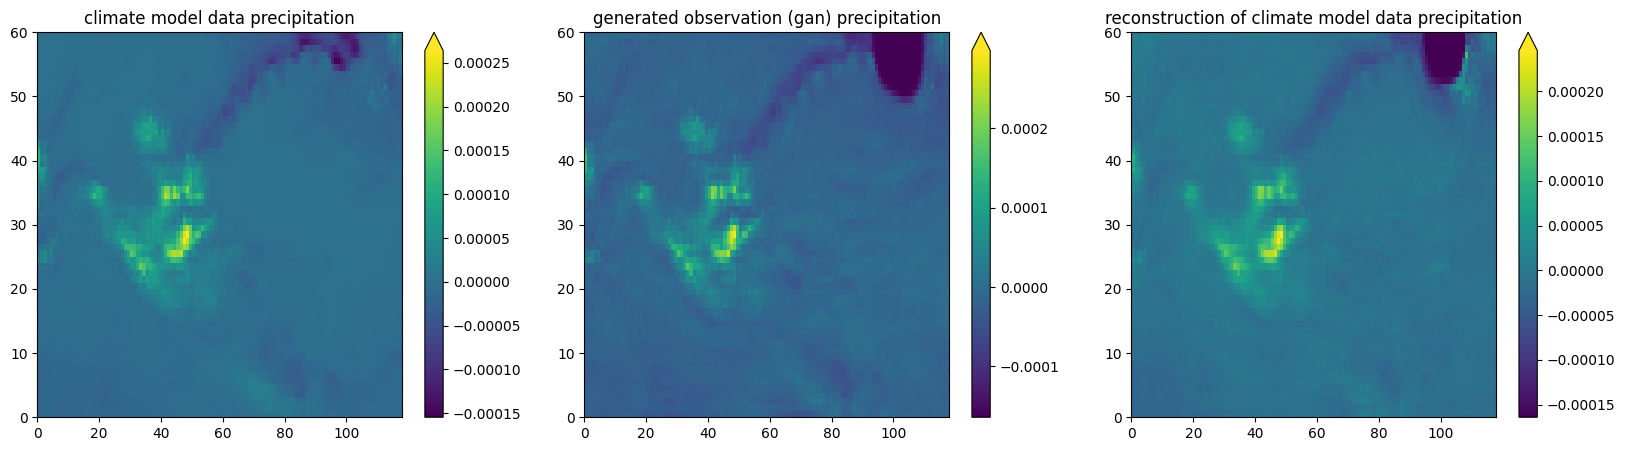

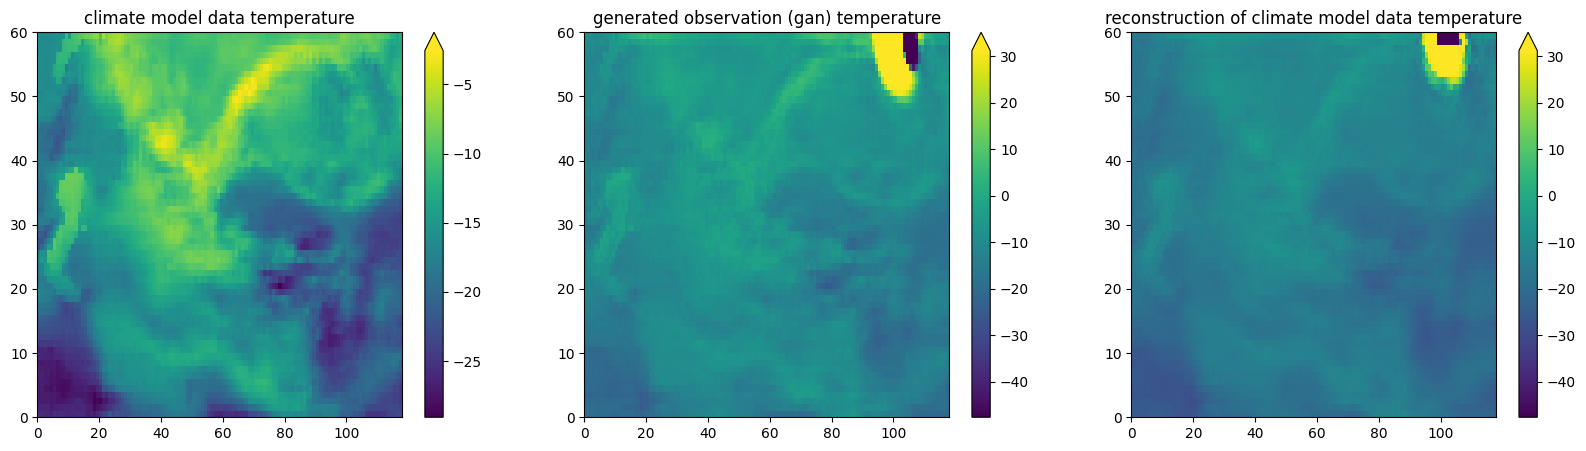

In [ ]:
for i in range(nbr_reconstruction_examples):
    test_data_ = dataset[i]  

    model = test_data_['B'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')).unsqueeze(0)
    gan = model_fw(model)
    rec = model_bw(gan)

    data_model = inv_transform(model.cpu()) 
    data_gan= inv_transform(gan.cpu())
    data_rec = inv_transform(rec.cpu())
    
    
    model_pr = data_model.squeeze(0)[0,:,:]
    model_t = data_model.squeeze(0)[1,:,:]

    gan_pr = data_gan.squeeze()[0,:,:]
    gan_t = data_gan.squeeze()[1,:,:]
    
    rec_pr = data_rec.squeeze()[0,:,:]
    rec_t = data_rec.squeeze()[1,:,:]


    print("average predicted error in precipitation:",np.round(torch.sum(abs(model_pr-gan_pr).cpu())/(60*118),5),"[K]")
    print("average predicted error in temperature:",np.round(torch.sum(abs(model_t-gan_t).cpu())/(60*118),0),"[K]")

    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    cs = ax[0].pcolormesh(model_pr.squeeze().cpu())
    norm = matplotlib.colors.Normalize(vmin=0, vmax=20)
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])

    fig.colorbar(cs, ax=ax[0], extend='max')
    ax[0].set_title("climate model data precipitation")

    cs = ax[1].pcolormesh(gan_pr.squeeze().cpu() )#, cmap="Blues")
    fig.colorbar(cs, ax=ax[1], extend='max')
    ax[1].set_title("generated observation (gan) precipitation")

    cs = ax[2].pcolormesh(rec_pr.squeeze().cpu() ) #, cmap="Blues")
    fig.colorbar(cs, ax=ax[2], extend='max')
    ax[2].set_title("reconstruction of climate model data precipitation")

    plt.show()
    
    
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    cs = ax[0].pcolormesh(model_t.squeeze().cpu())
    norm = matplotlib.colors.Normalize(vmin=0, vmax=20)
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])

    fig.colorbar(cs, ax=ax[0], extend='max')
    ax[0].set_title("climate model data temperature")

    cs = ax[1].pcolormesh(gan_t.squeeze().cpu() )#, cmap="Blues")
    fig.colorbar(cs, ax=ax[1], extend='max')
    ax[1].set_title("generated observation (gan) temperature")

    cs = ax[2].pcolormesh(rec_t.squeeze().cpu() ) #, cmap="Blues")
    fig.colorbar(cs, ax=ax[2], extend='max')
    ax[2].set_title("reconstruction of climate model data temperature")

    plt.show()

## reconstruction starting with observations

average predicted error in precipitation: tensor(3.0000e-05) [K]
average predicted error in temperature: tensor(8.) [K]


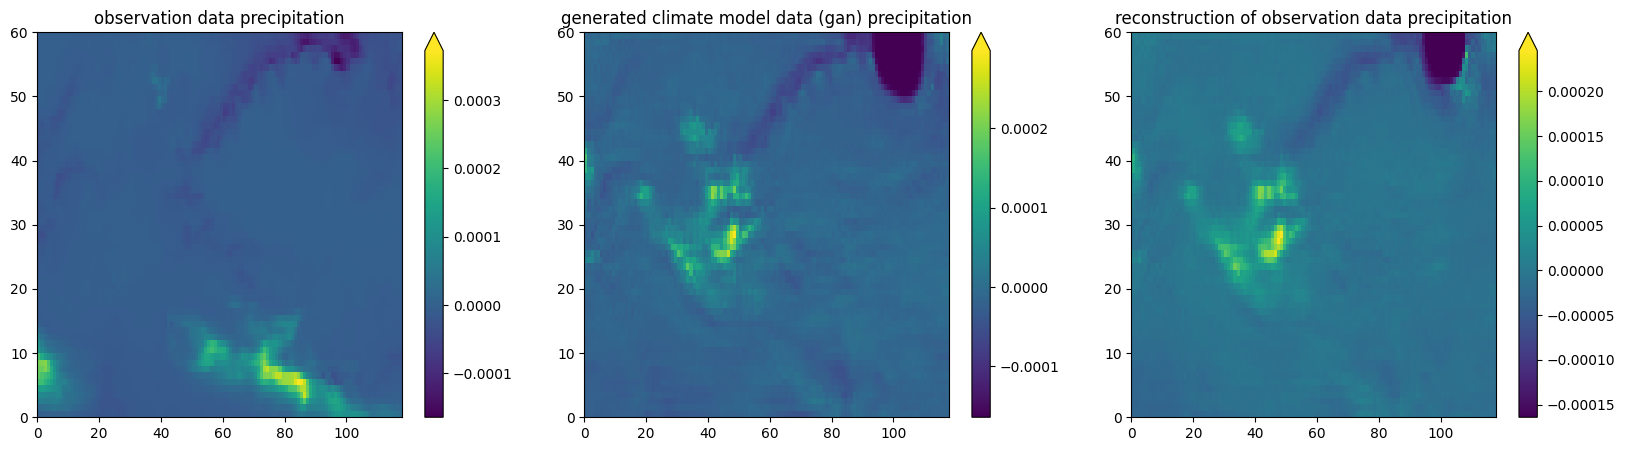

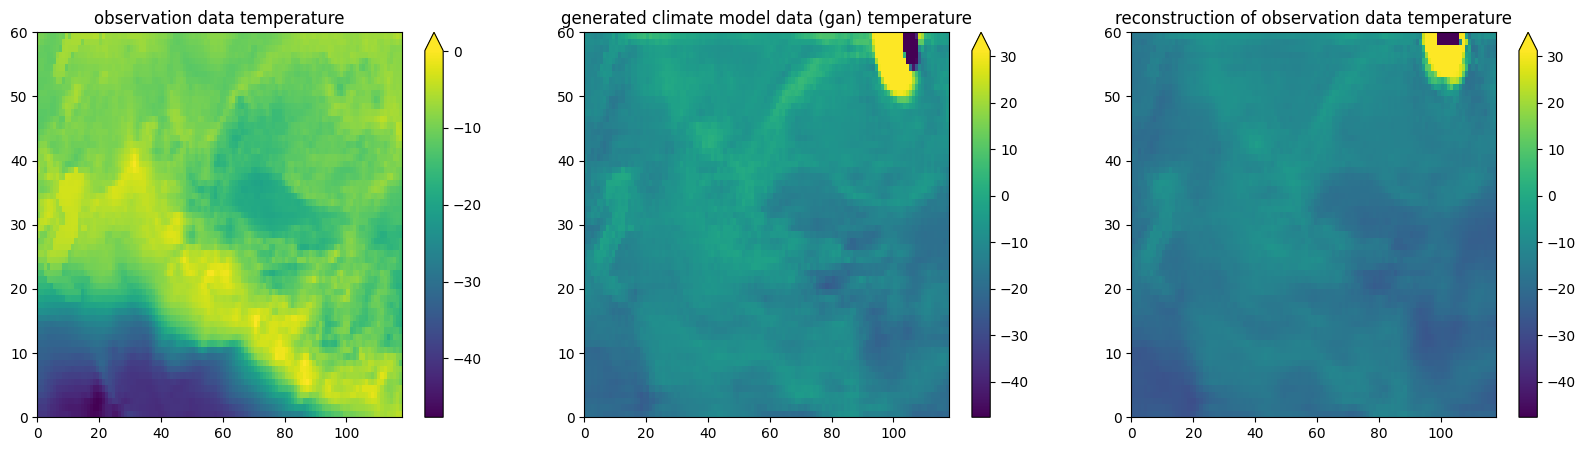

In [ ]:
for i in range(nbr_reconstruction_examples):
    test_data_ = dataset[i]  

    obs = test_data_['A'].to(torch.device('cuda' if torch.cuda.is_available() else 'cpu')).unsqueeze(0)
    gan = model_fw(model)
    rec = model_bw(gan)

    data_obs = inv_transform(obs.cpu()) 
    data_gan= inv_transform(gan.cpu())
    data_rec = inv_transform(rec.cpu())    
    
    obs_pr = data_obs.squeeze(0)[0,:,:]
    obs_t = data_obs.squeeze(0)[1,:,:]

    gan_pr = data_gan.squeeze()[0,:,:]
    gan_t = data_gan.squeeze()[1,:,:]
    
    rec_pr = data_rec.squeeze()[0,:,:]
    rec_t = data_rec.squeeze()[1,:,:]

    
    print("average predicted error in precipitation:",np.round(torch.sum(abs(obs_pr-gan_pr).cpu())/(60*118),5),"[K]")
    print("average predicted error in temperature:",np.round(torch.sum(abs(obs_t-gan_t).cpu())/(60*118),0),"[K]")

    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    cs = ax[0].pcolormesh(obs_pr.squeeze().cpu())
    norm = matplotlib.colors.Normalize(vmin=0, vmax=20)
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])

    fig.colorbar(cs, ax=ax[0], extend='max')
    ax[0].set_title("observation data precipitation")

    cs = ax[1].pcolormesh(gan_pr.squeeze().cpu() )#, cmap="Blues")
    fig.colorbar(cs, ax=ax[1], extend='max')
    ax[1].set_title("generated climate model data (gan) precipitation")

    cs = ax[2].pcolormesh(rec_pr.squeeze().cpu() ) #, cmap="Blues")
    fig.colorbar(cs, ax=ax[2], extend='max')
    ax[2].set_title("reconstruction of observation data precipitation")

    plt.show()
    
    
    
    fig, ax = plt.subplots(1, 3, figsize=(20, 5))

    cs = ax[0].pcolormesh(obs_t.squeeze().cpu())
    norm = matplotlib.colors.Normalize(vmin=0, vmax=20)
    sm = plt.cm.ScalarMappable(norm=norm)
    sm.set_array([])

    fig.colorbar(cs, ax=ax[0], extend='max')
    ax[0].set_title("observation data temperature")

    cs = ax[1].pcolormesh(gan_t.squeeze().cpu() )#, cmap="Blues")
    fig.colorbar(cs, ax=ax[1], extend='max')
    ax[1].set_title("generated climate model data (gan) temperature")

    cs = ax[2].pcolormesh(rec_t.squeeze().cpu() ) #, cmap="Blues")
    fig.colorbar(cs, ax=ax[2], extend='max')
    ax[2].set_title("reconstruction of observation data temperature")

    plt.show()

# Plot  **frames**

## Plot single frames

set the chose_day parameter to plot the precipitation on a specific day

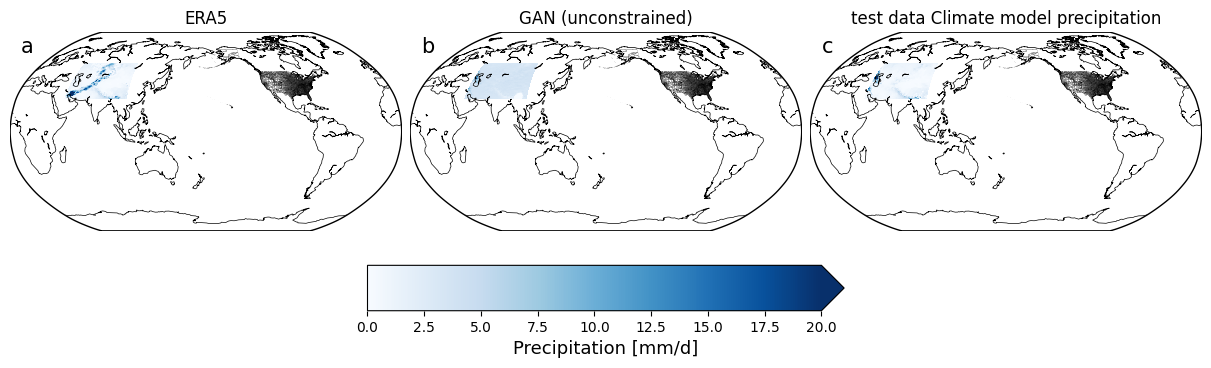

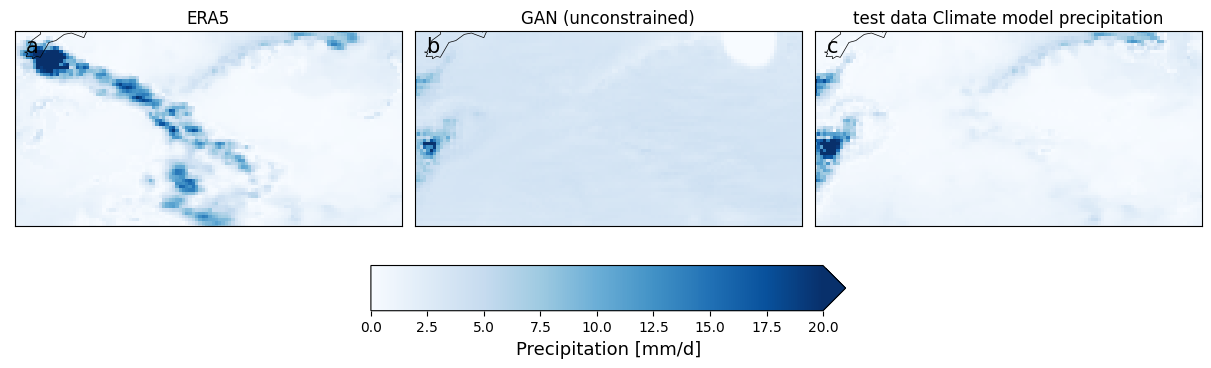

In [ ]:
chose_day=10

PlotAnalysis(test_data).single_frames_pr(time_index=chose_day)
PlotAnalysis(test_data).single_frames_pr(projection="cyl",time_index=chose_day)

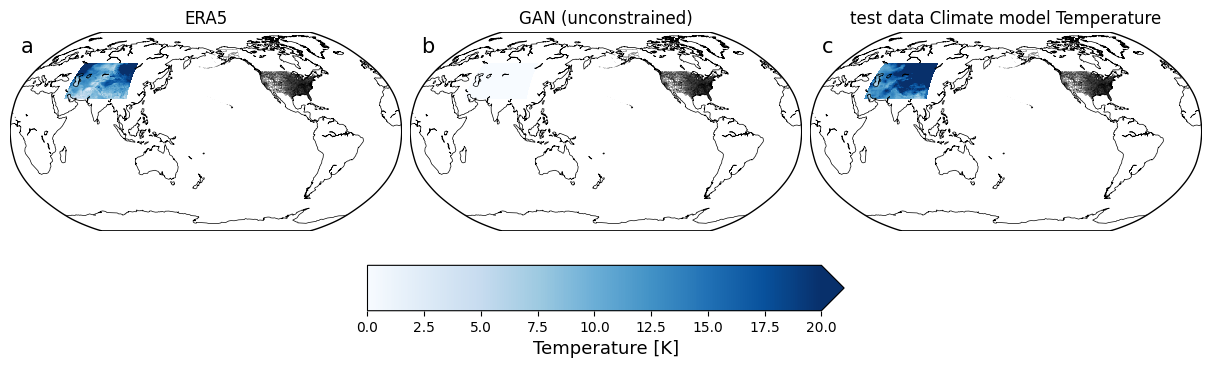

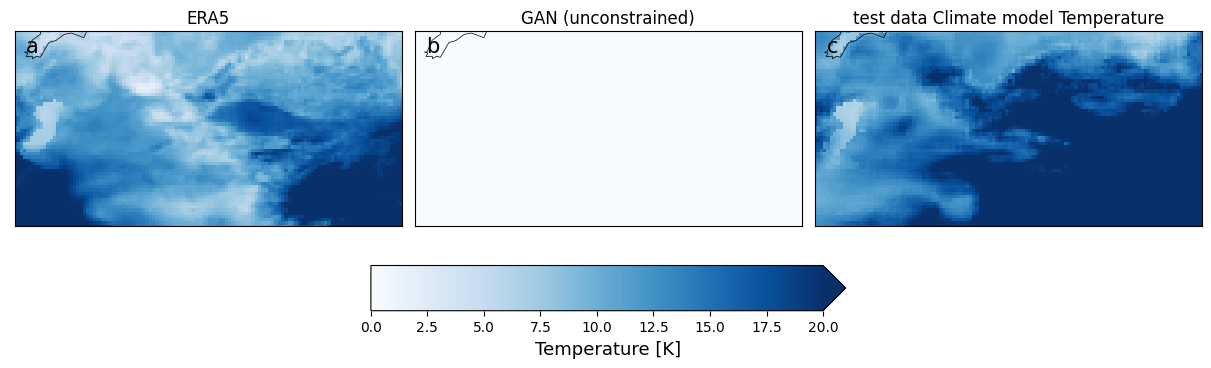

In [ ]:
PlotAnalysis(test_data).single_frames_t(time_index=chose_day)
PlotAnalysis(test_data).single_frames_t(projection="cyl",time_index=chose_day)

## plot of the average test_data for each data

In [ ]:
#PlotAnalysis(test_data).avg_frames(projection="cyl",scale_precip_by = 10)

## plot of the average **errors** between era5 & gan / climate_model

In [ ]:
#PlotAnalysis(test_data).avg_frames_abs_err(projection="cyl", scale_precip_by = 20)

**TODO**: plot spatial plot - mean Error - also show lands

# Plot **histogram** statistics
Precipitation rates averaged over time and longitudes and relative frequency histograms

## histogram no log

Here we plot the histogram over the daily precipitation values in the test dataset. 

In [ ]:
#fig, ax = plt.subplots(1,1,figsize=(4, 4),  constrained_layout=True)

#PlotAnalysis(test_data).histograms_pr(single_plot=False, ax=ax, show_legend=True, annotate=True,log=False,xlim_end=30)

In [ ]:
#PlotAnalysis(test_data).histograms_t(single_plot=False, ax=ax, show_legend=True, annotate=True,log=False,xlim_end=30)

## histogram log on **density**

Because it is hard to see anything because precipitations over 50 are very rare and thus the 3 plots are right above eachother, we apply the log to the probability desnity to better see the differences.

 Absolute Difference era5&climate_model (in test period): -335708

 Absolute Difference in percent era5&climate_model 1.5906

Area under the Histogram era5&climate_model 118361965
_______________________________________________________________

 Absolute Difference era5&gan (in test period): -107278672

 Absolute Difference in percent era5&gan 508.29153

Area under the Histogram era5&gan 153766070


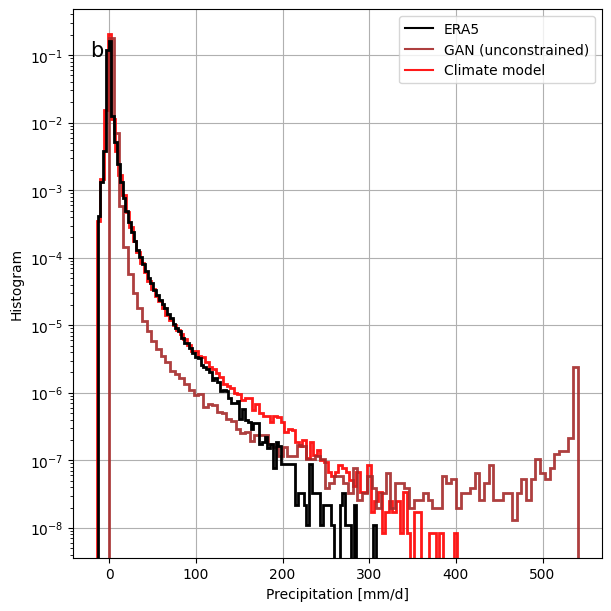

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6, 6),  constrained_layout=True)

PlotAnalysis(test_data).histograms_pr(single_plot=False, ax=ax, show_legend=True, annotate=True,log=True)

 Absolute Difference era5&climate_model (in test period): 2073728

 Absolute Difference in percent era5&climate_model 1.24585

Area under the Histogram era5&climate_model 22362073
_______________________________________________________________

 Absolute Difference era5&gan (in test period): -1707673

 Absolute Difference in percent era5&gan 1.02593

Area under the Histogram era5&gan 1780


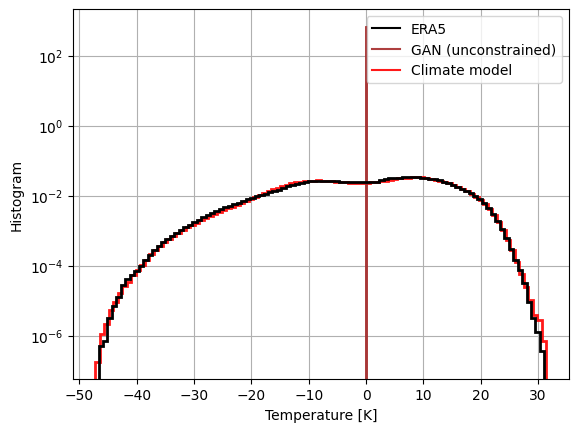

In [ ]:
PlotAnalysis(test_data).histograms_t(single_plot=False, ax=ax, show_legend=True, annotate=True,log=True)

## plot histogram log density **differences**

days in the test_data set

In [ ]:
len(getattr(test_data,"gan").time)

4018

Absolute Difference era5&climate_model (in test period): -335708

Absolute Difference in percent era5&climate_model 1.5906

Area under the Histogram era5&climate_model 117401089
_______________________________________________________________

Absolute Difference era5&gan (in test period): -107278672

Absolute Difference in percent era5&gan 508.29153

Area under the Histogram era5&gan 154616434


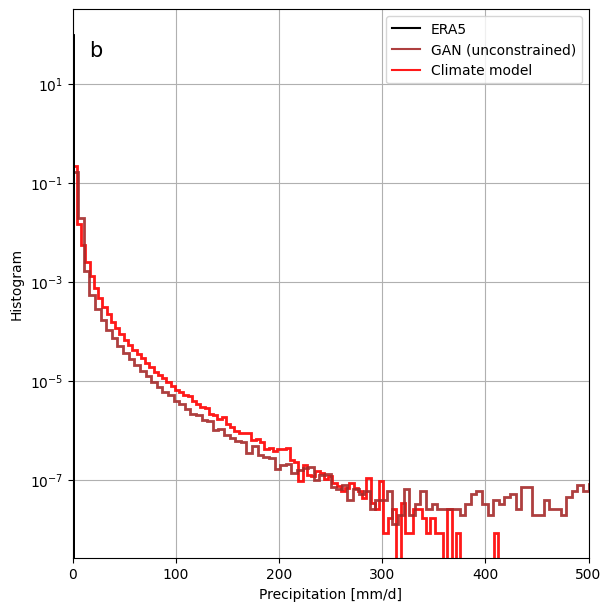

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(6, 6),  constrained_layout=True)

PlotAnalysis(test_data).histogram_diff_pr(single_plot=False, ax=ax, show_legend=True, annotate=True)

Absolute Difference era5&climate_model (in test period): 2073728

Absolute Difference in percent era5&climate_model 1.24585

Area under the Histogram era5&climate_model 11295459
_______________________________________________________________

Absolute Difference era5&gan (in test period): -1707673

Absolute Difference in percent era5&gan 1.02593

Area under the Histogram era5&gan 13265891


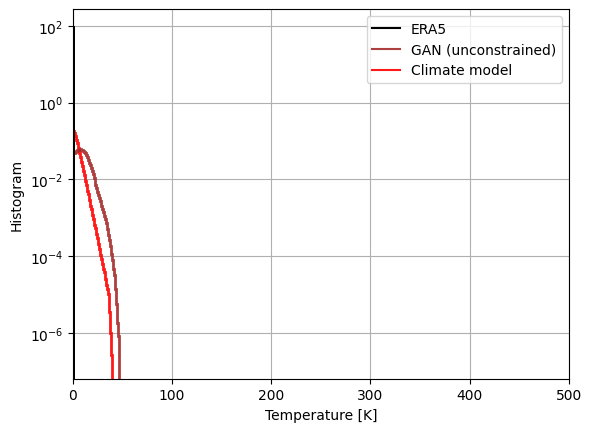

In [ ]:
PlotAnalysis(test_data).histogram_diff_t(single_plot=False, ax=ax, show_legend=True, annotate=True)

## plot log **precipitation**

Applying the **log** to the data itself instead of to the amount of points in the bins as in the plot before results in the density to be on one scale:

In [ ]:
#fig, ax = plt.subplots(1,1,figsize=(6, 6),  constrained_layout=True)
#PlotAnalysis(test_data).log_histograms(single_plot=False, ax=ax, show_legend=True, annotate=True)

## plot histogram log precipitation differences

In [ ]:
#PlotAnalysis(test_data).log_histogram_diff(single_plot=False, ax=ax, show_legend=True, annotate=True)

# Plot **latitudinal** **mean**

Climate model  	 	 MAE: 0.043 [mm/d]
GAN (unconstrained)  	 	 MAE: 3.771 [mm/d]


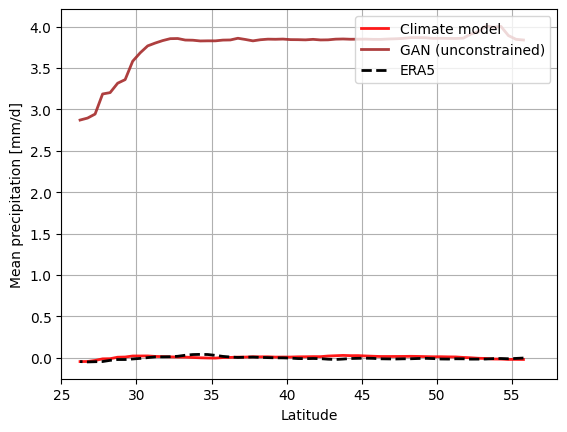

In [ ]:
PlotAnalysis(test_data).latitudinal_mean_pr()

Climate model  	 	 MAE: 0.126 [mm/d]
GAN (unconstrained)  	 	 MAE: 0.082 [mm/d]


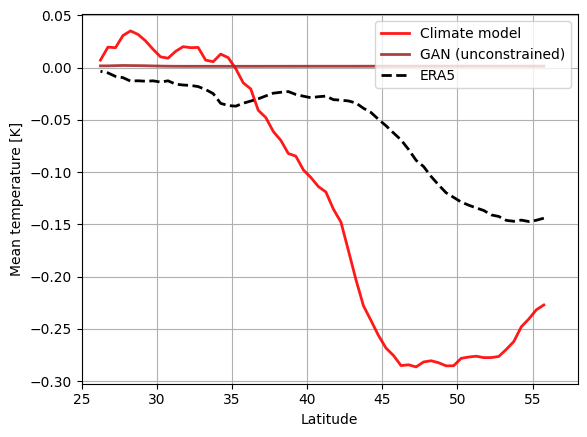

In [ ]:
PlotAnalysis(test_data).latitudinal_mean_t()